# Package Imports

In [ ]:
import numpy as np
import pandas as pd 
import csv
import re
from itertools import combinations
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm

Download the Dbpedia dataset and unzip it to get the ttl file 

In [ ]:
! wget -c https://downloads.dbpedia.org/repo/dbpedia/mappings/mappingbased-objects/2020.08.01/mappingbased-objects_lang=en.ttl.bz2
!bzip2 -d mappingbased-objects_lang=en.ttl.bz2

--2020-09-12 12:00:51--  https://downloads.dbpedia.org/repo/dbpedia/mappings/mappingbased-objects/2020.08.01/mappingbased-objects_lang=en.ttl.bz2
Resolving downloads.dbpedia.org (downloads.dbpedia.org)... 139.18.16.66
Connecting to downloads.dbpedia.org (downloads.dbpedia.org)|139.18.16.66|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 166689661 (159M) [application/octet-stream]
Saving to: ‘mappingbased-objects_lang=en.ttl.bz2’

mappingbased-object 100%[===================>] 158.97M  18.1MB/s    in 9.8s    

2020-09-12 12:01:01 (16.2 MB/s) - ‘mappingbased-objects_lang=en.ttl.bz2’ saved [166689661/166689661]

bzip2: Output file mappingbased-objects_lang=en.ttl already exists.


In [ ]:
!ls

 actors_node_pair.csv  'mappingbased-objects_lang=en.ttl'       sample_data
 data.csv	       'mappingbased-objects_lang=en.ttl.bz2'


Identirying the number of entries in the dataset

In [ ]:
! wc -l mappingbased-objects_lang=en.ttl

20220638 mappingbased-objects_lang=en.ttl


# Convert ttl to CSV

Write the datatset to csv using regex to make sense of the links. Counting the empty lines.

In [ ]:
csv_file = open('data.csv', 'w')
csv_writer = csv.writer(csv_file)
csv_writer.writerow(['subject', 'predicate', 'object'])
empty = 0
with open("mappingbased-objects_lang=en.ttl") as myfile:
    for line in myfile: 
      formatedline = re.compile(r'<http://dbpedia.org/resource/(.*)> <http://dbpedia.org/ontology/(.*)> <http://dbpedia.org/resource/(.*)>') 
      if (formatedline.findall(line)):
        csv_writer.writerow([formatedline.findall(line)[0][0], formatedline.findall(line)[0][1], formatedline.findall(line)[0][2]])
      else: 
        empty += 1

print(f'{empty} lines were empty')

699152 lines were empty


Taking a look at the newly created file 

In [ ]:
df = pd.read_csv("data.csv") 
df.head()

,subject,predicate,object
0,!!!,associatedBand,Maserati_(band)
1,!!!,associatedBand,Out_Hud
2,!!!,associatedMusicalArtist,Maserati_(band)
3,!!!,associatedMusicalArtist,Out_Hud
4,!!!,bandMember,Nic_Offer


# Filter out the values with predicate/relationship as starring 

Checking the unique categories of predicates/relationships

In [ ]:
df['predicate'].unique()

array(['associatedBand', 'associatedMusicalArtist', 'bandMember',
       'formerBandMember', 'genre', 'hometown', 'recordLabel', 'basedOn',
       'musicBy', 'company', 'country', 'director', 'format', 'language',
       'location', 'network', 'openingTheme', 'related', 'starring',
       'birthPlace', 'distributor', 'editing', 'musicComposer',
       'producer', 'writer', 'album', 'artist', 'previousWork',
       'subsequentWork', 'productionCompany', 'cinematography',
       'presenter', 'composer', 'creator', 'launchVehicle', 'nextMission',
       'operator', 'previousMission', 'editor', 'publisher', 'author',
       'literaryGenre', 'occupation', 'party', 'termPeriod',
       'predecessor', 'successor', 'ideology', 'splitFromParty',
       'deathPlace', 'binomialAuthority', 'class', 'family', 'genus',
       'kingdom', 'order', 'phylum', 'headquarter', 'religion',
       'affiliation', 'leaderFunction', 'person', 'recordedIn',
       'mediaType', 'instrument', 'architecturalStyle',

Looking at the distribution of predicates 

In [ ]:
df['predicate'].value_counts()

team                    2692510
careerStation           1461214
birthPlace              1298683
subdivision             1067562
country                  778064
                         ...   
headteacher                   1
actScore                      1
winsAtProTournaments          1
sourceMountain                1
sourcePlace                   1
Name: predicate, Length: 626, dtype: int64

Creating a new dataframe for the starring relationships 

In [ ]:
starring_df = df [df['predicate']=='starring']
starring_df.head(20)

,subject,predicate,object
38,!Oka_Tokat,starring,Agot_Isidro
39,!Oka_Tokat,starring,Ang_TV
40,!Oka_Tokat,starring,Angelika_Dela_Cruz
41,!Oka_Tokat,starring,Diether_Ocampo
42,!Oka_Tokat,starring,Jericho_Rosales
43,!Oka_Tokat,starring,Paolo_Contis
44,!Oka_Tokat,starring,Rica_Peralejo
45,!Oka_Tokat,starring,Ricky_Davao
74,"$1,000_Reward",starring,Jane_Fairbanks
75,"$1,000_Reward",starring,Madeline_Fairbanks


#Data Transformations 

Looking at the starring relationship data 

In [ ]:
starring_df.shape

(347339, 3)

In [ ]:
len(starring_df['object'].unique())

97592

In [ ]:
starring_df['object'].value_counts()

Prem_Nazir            504
Mel_Blanc             484
Adoor_Bhasi           365
Mammootty             354
Mithun_Chakraborty    331
                     ... 
Cassandra_Kane          1
Blaze_Starr             1
Robyn_Bliley            1
Tony_Hippolyte          1
Zhao_Kuie               1
Name: object, Length: 97592, dtype: int64

Drop the predicate col, reset index of the dataframe.

*Droped some of the values to **lower computational cost**.*

In [ ]:
starring_df = starring_df.drop(['predicate'], axis=1)
starring_df.reset_index(inplace = True, drop = True) 
starring_df = starring_df[:round(starring_df.shape[0]/1000)]
starring_df.head()

,subject,object
0,!Oka_Tokat,Agot_Isidro
1,!Oka_Tokat,Ang_TV
2,!Oka_Tokat,Angelika_Dela_Cruz
3,!Oka_Tokat,Diether_Ocampo
4,!Oka_Tokat,Jericho_Rosales


Encoding Object and Subject categories 

In [ ]:
lb_make = LabelEncoder()
starring_df["actor_code"] = lb_make.fit_transform(starring_df["object"])
starring_df["movie_code"] = lb_make.fit_transform(starring_df["subject"])
starring_df.head()

,subject,object,actor_code,movie_code
0,!Oka_Tokat,Agot_Isidro,2,0
1,!Oka_Tokat,Ang_TV,18,0
2,!Oka_Tokat,Angelika_Dela_Cruz,19,0
3,!Oka_Tokat,Diether_Ocampo,69,0
4,!Oka_Tokat,Jericho_Rosales,147,0


In [ ]:
print(starring_df[starring_df["actor_code"] == 1])
print(starring_df.shape)

               subject         object  actor_code  movie_code
94  'N_Beetje_Verliefd  Ad_van_Kempen           1          25
(347, 4)


In [ ]:
# from tqdm import tqdm

# node_list_1 = []
# node_list_2 = []

# for index, row1 in tqdm(starring_df.iterrows()):
#   for index, row2 in starring_df.iterrows():
#     if row1["movie_code"] == row2["movie_code"]:
#       node_list_1.append(row1["actor_code"])
#       node_list_2.append(row2["actor_code"])

# node_df = pd.DataFrame({'node_1': node_list_1, 'node_2': node_list_2})

In [ ]:
# node_df.head()

Testing if node pair concersion code works

In [ ]:
#combination test 
iter_comb_test_df = starring_df[starring_df["movie_code"] == 0]
print(iter_comb_test_df)

node_node_df_test = list(combinations(iter_comb_test_df.actor_code, 2))
print(node_node_df_test)

      subject              object  actor_code  movie_code
0  !Oka_Tokat         Agot_Isidro           2           0
1  !Oka_Tokat              Ang_TV          18           0
2  !Oka_Tokat  Angelika_Dela_Cruz          19           0
3  !Oka_Tokat      Diether_Ocampo          69           0
4  !Oka_Tokat     Jericho_Rosales         147           0
5  !Oka_Tokat        Paolo_Contis         235           0
6  !Oka_Tokat       Rica_Peralejo         251           0
7  !Oka_Tokat         Ricky_Davao         256           0
[(2, 18), (2, 19), (2, 69), (2, 147), (2, 235), (2, 251), (2, 256), (18, 19), (18, 69), (18, 147), (18, 235), (18, 251), (18, 256), (19, 69), (19, 147), (19, 235), (19, 251), (19, 256), (69, 147), (69, 235), (69, 251), (69, 256), (147, 235), (147, 251), (147, 256), (235, 251), (235, 256), (251, 256)]


Converting the dataframe to node pairs, where each pair has an edge between them.

In [ ]:
node_list_1 = []
node_list_2 = []

for movie in starring_df.movie_code:
  iter_comb_df = starring_df[starring_df["movie_code"] == movie]
  node_node_df = list(combinations(iter_comb_df.actor_code, 2))
  for node_pair in node_node_df:
    node_list_1.append(node_pair[0])
    node_list_2.append(node_pair[1])
  # print(movie, node_node_df)

In [ ]:
actors_df = pd.DataFrame({'node_1': node_list_1, 'node_2': node_list_2})

In [ ]:
actors_df.shape

(10342, 2)

In [ ]:
actors_df.head()

,node_1,node_2
0,2,18
1,2,19
2,2,69
3,2,147
4,2,235


In [ ]:
actors_df.sort_values(by=['node_1'], inplace=True)
actors_df.reset_index(inplace = True, drop = True) 

In [ ]:
actors_df.head()

,node_1,node_2
0,1,94
1,1,94
2,1,327
3,1,94
4,1,327


Saving the node pair dataframe as csv to save time.

In [ ]:
actors_df.to_csv('actors_node_pair.csv',index=False)

In [ ]:
actors_df = pd.read_csv("actors_node_pair.csv") 
# actors_df = actors_df[:round(actors_df.shape[0]/1000)]
print(actors_df)

       node_1  node_2
0           1      94
1           1      94
2           1     327
3           1      94
4           1     327
...       ...     ...
10337     318     321
10338     318     321
10339     322     323
10340     322     323
10341     322     323

[10342 rows x 2 columns]


Converting the nodepair dataframe to a NetworkX graph.

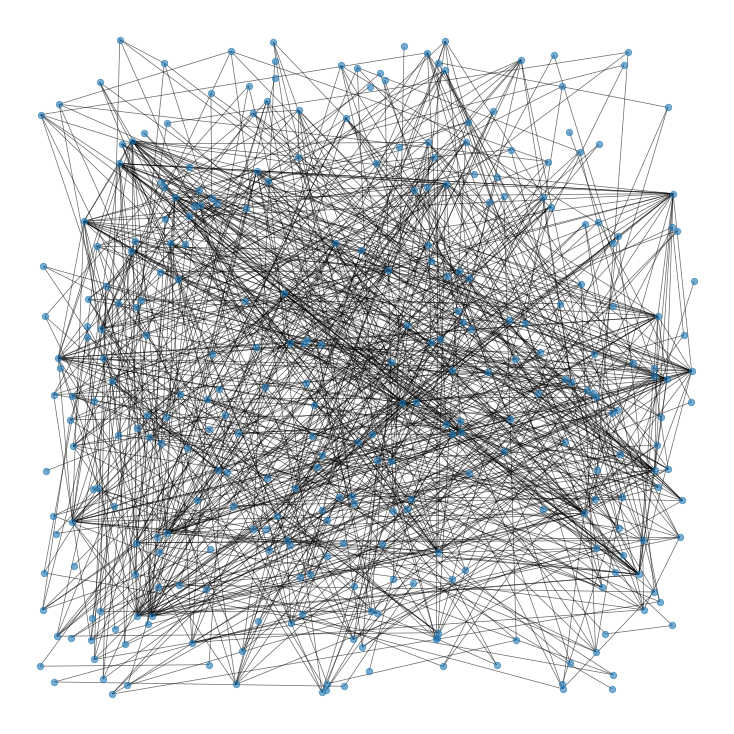

In [ ]:
# create graph
G = nx.from_pandas_edgelist(actors_df, "node_1", "node_2", create_using=nx.Graph())

# plot graph
plt.figure(figsize=(10,10))

pos = nx.random_layout(G, seed=23)
nx.draw(G, with_labels=False,  pos = pos, node_size = 40, alpha = 0.6, width = 0.7)

plt.show()

Creating a list of all unique nodes in the dataset

In [ ]:
# combine all nodes in a list
actor_node_list = actors_df["node_1"].tolist() + actors_df["node_2"].tolist()

# remove duplicate items from the list
actor_node_list = list(dict.fromkeys(actor_node_list))

Building an adjacency matrix 

In [ ]:
# build adjacency matrix
adj_G = nx.to_numpy_matrix(G, nodelist = actor_node_list)

In [ ]:
adj_G.shape

(309, 309)

### Negative Samples 

Making the list of all the unconnected node pairs(where future relations can be formed)

In [ ]:
# get unconnected node-pairs
all_unconnected_pairs = []

# traverse adjacency matrix
offset = 0
for i in tqdm(range(adj_G.shape[0])):
  for j in range(offset,adj_G.shape[1]):
    if i != j:
      try:
        if nx.shortest_path_length(G, i, j) <= 2:  
          if adj_G[i,j] == 0:
            all_unconnected_pairs.append([actor_node_list[i],actor_node_list[j]])
      except:
        pass

  offset = offset + 1


100%|██████████| 309/309 [00:00<00:00, 576.12it/s]


In [ ]:
len(all_unconnected_pairs)

856

In [ ]:
node_1_unlinked = [i[0] for i in all_unconnected_pairs]
node_2_unlinked = [i[1] for i in all_unconnected_pairs]

model_data = pd.DataFrame({'node_1':node_1_unlinked, 
                     'node_2':node_2_unlinked})

# add target variable 'link'
model_data['link'] = 0

### Positive Samples 

R andomly drop some of the edges from the graph to get some positive training samples. While making sure that in the process of dropping edges, all the nodes of the graph should remain connected.

In [ ]:
print(nx.number_connected_components(G))

70


In [ ]:
initial_node_count = len(G.nodes)

actors_df_temp = actors_df.copy()

# empty list to store removable links
omissible_links_index = []

for i in tqdm(actors_df.index.values):
  
  # remove a node pair and build a new graph
  G_temp = nx.from_pandas_edgelist(actors_df_temp.drop(index = i), "node_1", "node_2", create_using=nx.Graph())
  # check there is no spliting of graph and number of nodes is same
  if (nx.number_connected_components(G_temp) == 70) and (len(G_temp.nodes) == initial_node_count):
    omissible_links_index.append(i)
    actors_df_temp = actors_df_temp.drop(index = i)


100%|██████████| 10342/10342 [01:46<00:00, 97.06it/s] 


In [ ]:
len(omissible_links_index)

10103

Creating a new dataframe for model training.
* Adding negative and positive samples to the training data.
* Adding the presence/absence of a link as a target variable.

In [ ]:
# create dataframe of removable edges
actors_df_ghost = actors_df.loc[omissible_links_index]

# add the target variable 'link'
actors_df_ghost['link'] = 1

model_data = model_data.append(actors_df_ghost[['node_1', 'node_2', 'link']], ignore_index=True)

In [ ]:
model_data['link'].value_counts()

1    10103
0      856
Name: link, dtype: int64

# Feature Extraction

Use the node2vec algorithm to extract node features from the graph after dropping the links

In [ ]:
# drop removable edges
actors_df_partial = actors_df.drop(index=actors_df_ghost.index.values)

# build graph
G_data = nx.from_pandas_edgelist(actors_df_partial, "node_1", "node_2", create_using=nx.Graph())

In [ ]:
!pip install node2vec

In [ ]:
from node2vec import Node2Vec

# Generate walks
node2vec = Node2Vec(G_data, dimensions=100, walk_length=16, num_walks=50)

# train node2vec model
n2w_model = node2vec.fit(window=10, min_count=1)


Computing transition probabilities: 100%|██████████| 309/309 [00:00<00:00, 10831.56it/s]

Generating walks (CPU: 1): 100%|██████████| 50/50 [00:10<00:00,  4.89it/s]


Apply the trained node2vec model on each and every node pair in the model trining dataframe. To compute the features of a pair or an edge.

In [ ]:
x = [(n2w_model[str(i)]+n2w_model[str(j)]) for i,j in zip(model_data['node_1'], model_data['node_2'])]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


# Building the Link Prediction Model

In [ ]:
xtrain, xtest, ytrain, ytest = train_test_split(np.array(x), model_data['link'], 
                                                test_size = 0.3, 
                                                random_state = 35)

In [ ]:
lr = LogisticRegression(class_weight="balanced", max_iter= 1000)

lr.fit(xtrain, ytrain)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
predictions = lr.predict_proba(xtest)

In [ ]:
roc_auc_score(ytest, predictions[:,1])

0.9227104878146545

Got a ROC Accuracy score of 0.92 using a logistic regression model which is not bad. Therefore predictions of future relations were made based on this model.

In [ ]:
print(actors_df.shape)
print(model_data.shape)
print(np.array(x).shape)

(10342, 2)
(10959, 3)
(10959, 100)


In [ ]:
print(np.array(x).shape)

(10959, 100)


In [ ]:
future_costar_predictions = lr.predict_proba(x)

In [ ]:
future_costar_predictions.shape

(10959, 2)

Adding the predictions to a dataframe with actor codes.

In [ ]:
costars = pd.DataFrame({'Actor1_code': model_data['node_1'], 'Actor2_code':model_data['node_2'], 'Probability': future_costar_predictions[:, 1]})

In [ ]:
costars.head()

,Actor1_code,Actor2_code,Probability
0,2,101,0.039390
1,3,19,0.244503
2,3,74,0.092456
3,3,165,0.105309
4,3,219,0.386334


Transform the dataframe to contain actor names and probability of future partnerships to make it human readable. 

In [ ]:
for index_starring, row_starring in tqdm(starring_df.iterrows()):
  for index_costars, row_costars in costars.iterrows(): 
    if row_starring["actor_code"] == row_costars['Actor1_code']:
      costars.loc[index_costars, "Actor1"] = starring_df.loc[index_starring, "object"]
    if row_starring["actor_code"] == row_costars['Actor2_code']:
      costars.loc[index_costars, "Actor2"] = starring_df.loc[index_starring, "object"]


0it [00:00, ?it/s]
1it [00:01,  1.49s/it]
2it [00:02,  1.49s/it]
3it [00:04,  1.51s/it]
4it [00:06,  1.51s/it]
5it [00:07,  1.51s/it]
6it [00:09,  1.52s/it]
7it [00:10,  1.53s/it]
8it [00:12,  1.52s/it]
9it [00:13,  1.50s/it]
10it [00:15,  1.49s/it]
11it [00:16,  1.48s/it]
12it [00:18,  1.48s/it]
13it [00:19,  1.48s/it]
14it [00:20,  1.47s/it]
15it [00:22,  1.47s/it]
16it [00:23,  1.47s/it]
17it [00:25,  1.45s/it]
18it [00:26,  1.45s/it]
19it [00:28,  1.44s/it]
20it [00:29,  1.45s/it]
21it [00:31,  1.44s/it]
22it [00:32,  1.44s/it]
23it [00:33,  1.45s/it]
24it [00:35,  1.43s/it]
25it [00:36,  1.43s/it]
26it [00:38,  1.43s/it]
27it [00:39,  1.44s/it]
28it [00:41,  1.43s/it]
29it [00:42,  1.45s/it]
30it [00:44,  1.45s/it]
31it [00:45,  1.46s/it]
32it [00:47,  1.48s/it]
33it [00:48,  1.48s/it]
34it [00:50,  1.49s/it]
35it [00:51,  1.49s/it]
36it [00:53,  1.49s/it]
37it [00:54,  1.48s/it]
38it [00:55,  1.46s/it]
39it [00:57,  1.45s/it]
40it [00:58,  1.44s/it]
41it [01:00,  1.43s/it]
42it 

In [ ]:
costars.head()

,Actor1_code,Actor2_code,Probability,Actor1,Actor2
0,2,101,0.039390,Agot_Isidro,Giancarlo_Giannini
1,3,19,0.244503,Aisha_Tyler,Angelika_Dela_Cruz
2,3,74,0.092456,Aisha_Tyler,Dulquer_Salmaan
3,3,165,0.105309,Aisha_Tyler,Kali_N._Rathnam
4,3,219,0.386334,Aisha_Tyler,Mylene_Dizon
